In [1]:
from setup import *
from utils import (
    load_data, 
    add_features, 
    add_labels, 
    plot_cumulative_returns, 
    split_data,
    plot_precision,
    calculate_returns
    )
import numpy as np
import matplotlib.pyplot as plt

In [2]:
asset_data = load_data("USDBRL=X", "2020-01-01", "2023-10-01")
asset_data = add_features(add_labels(asset_data))
asset_data.head()

/home/felipe-nicoletti/Projetos/Pessoal/market-data-market-prediction-ml-study/utils.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date, interval="1wk")
[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume,target,returns,volatility,ma_4,ma_12,ma_ratio
Date,,,,,,,,,,,
2020-03-18,5.1417,5.2105,4.976100,5.009900,0,1,0.028546,0.021153,4.834000,4.434806,1.090014
2020-03-25,5.1927,5.2040,4.973900,5.098600,0,1,0.009919,0.013171,5.014075,4.529165,1.107064
2020-04-01,5.2853,5.3513,5.185842,5.203900,0,0,0.017833,0.005596,5.154675,4.624123,1.114736
2020-04-08,5.1985,5.2447,5.050000,5.221600,0,1,-0.016423,0.024222,5.204550,4.708290,1.105401
2020-04-15,5.3154,5.3173,5.159709,5.160036,0,1,0.022487,0.027514,5.247975,4.800731,1.093162


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [4]:
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=1))
])

In [5]:
X = asset_data[["ma_ratio", "ma_4", "volatility", "Close"]]
y = asset_data["target"]

X_train, X_test, y_train, y_test = split_data(
    X,
    y
)

In [6]:
pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001


In [7]:
predictions = pipeline.predict(X_test)

In [8]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, target_names=["Down", "Up"]))

              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        28
          Up       0.50      1.00      0.67        28

    accuracy                           0.50        56
   macro avg       0.25      0.50      0.33        56
weighted avg       0.25      0.50      0.33        56



/home/felipe-nicoletti/Projetos/Pessoal/market-data-market-prediction-ml-study/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felipe-nicoletti/Projetos/Pessoal/market-data-market-prediction-ml-study/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felipe-nicoletti/Projetos/Pessoal/market-data-market-prediction-ml-study/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being se

## Como podemos observar os dados não se comportam bem com SVC puro pois não apresentam um bom nível de separação linear. Faremos um experimento utilizando features polinomiais para tentar criar uma separação linear entre as classes.

In [9]:
from sklearn.preprocessing import PolynomialFeatures

pipeline_with_poly = Pipeline([
    ("poly", PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm", LinearSVC(C=10, loss="hinge"))
])

In [10]:
pipeline_with_poly.fit(X_train, y_train)

/home/felipe-nicoletti/Projetos/Pessoal/market-data-market-prediction-ml-study/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,steps,"[('poly', ...), ('scaler', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,degree,3
,interaction_only,False
,include_bias,True
,order,'C'
,copy,True
,with_mean,True
,with_std,True


In [11]:
poly_predictions = pipeline_with_poly.predict(X_test)

In [12]:
print(classification_report(y_test, poly_predictions, target_names=["Down", "Up"]))

              precision    recall  f1-score   support

        Down       0.00      0.00      0.00        28
          Up       0.50      1.00      0.67        28

    accuracy                           0.50        56
   macro avg       0.25      0.50      0.33        56
weighted avg       0.25      0.50      0.33        56



/home/felipe-nicoletti/Projetos/Pessoal/market-data-market-prediction-ml-study/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felipe-nicoletti/Projetos/Pessoal/market-data-market-prediction-ml-study/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/felipe-nicoletti/Projetos/Pessoal/market-data-market-prediction-ml-study/env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being se

## Como foi possivel observar mesmo com o uso de features polinomiais o modelo não conseguiu separar as classes de forma satisfatória. Vamos agora utilizar o SVC com kernel radial para tentar melhorar a separação entre as classes.

In [13]:
from sklearn.svm import SVC
poly_kernel_svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="poly", degree=4, C=40, coef0=1))
])

poly_kernel_svm_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('svm', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,C,40
,kernel,'poly'
,degree,4
,gamma,'scale'


In [14]:
poly_kernel_predictions = poly_kernel_svm_pipeline.predict(X_test)

In [15]:
print(classification_report(y_test, poly_kernel_predictions, target_names=["Down", "Up"]))

              precision    recall  f1-score   support

        Down       0.63      0.43      0.51        28
          Up       0.57      0.75      0.65        28

    accuracy                           0.59        56
   macro avg       0.60      0.59      0.58        56
weighted avg       0.60      0.59      0.58        56



In [16]:
scores = poly_kernel_svm_pipeline.decision_function(X_test)

within_margin = np.abs(scores) < 1
outside_margin = ~within_margin

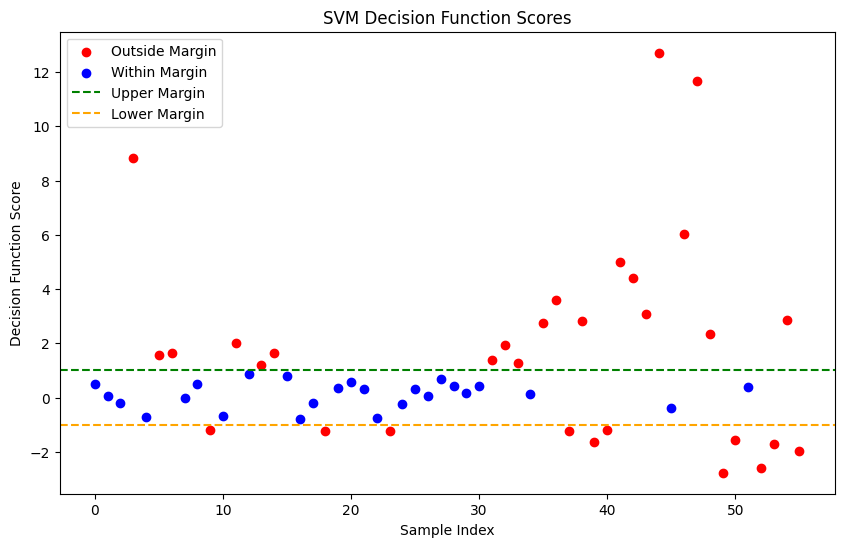

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(
    np.arange(len(scores))[outside_margin],
    scores[outside_margin],
    color="red",
    label="Outside Margin",
)

plt.scatter(
    np.arange(len(scores))[within_margin],
    scores[within_margin],
    color="blue",
    label="Within Margin",
)
plt.axhline(1, color="green", linestyle="--", label="Upper Margin")
plt.axhline(-1, color="orange", linestyle="--", label="Lower Margin")
plt.title("SVM Decision Function Scores")
plt.xlabel("Sample Index")
plt.ylabel("Decision Function Score")
plt.legend()
plt.show()

## Aqui podemos perceber que conseguimos obter resultados melhores com SVM a partir do momento em que os dados são redimensionados com o uso do SVC

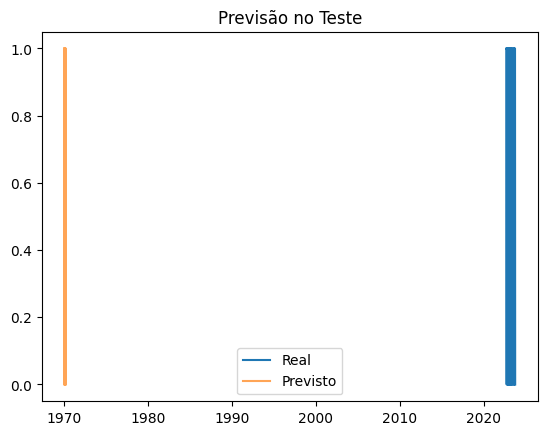

In [18]:
plot_precision(y_test, poly_kernel_predictions)

In [19]:
all_predictions = poly_kernel_svm_pipeline.predict(X)

asset_data = calculate_returns(asset_data, all_predictions)
asset_data.head()

,Close,High,Low,Open,Volume,target,returns,volatility,ma_4,ma_12,ma_ratio,predicted_target,real_return,cumulative_real_return,cumulative_predicted_return
Date,,,,,,,,,,,,,,,
2020-03-18,5.1417,5.2105,4.976100,5.009900,0,1,0.028546,0.021153,4.834000,4.434806,1.090014,1,0.028546,1.028546,1.028546
2020-03-25,5.1927,5.2040,4.973900,5.098600,0,1,0.009919,0.013171,5.014075,4.529165,1.107064,1,0.009919,1.038748,1.038748
2020-04-01,5.2853,5.3513,5.185842,5.203900,0,0,0.017833,0.005596,5.154675,4.624123,1.114736,0,0.000000,1.057271,1.038748
2020-04-08,5.1985,5.2447,5.050000,5.221600,0,1,-0.016423,0.024222,5.204550,4.708290,1.105401,1,-0.016423,1.039908,1.021689
2020-04-15,5.3154,5.3173,5.159709,5.160036,0,1,0.022487,0.027514,5.247975,4.800731,1.093162,1,0.022487,1.063293,1.044663


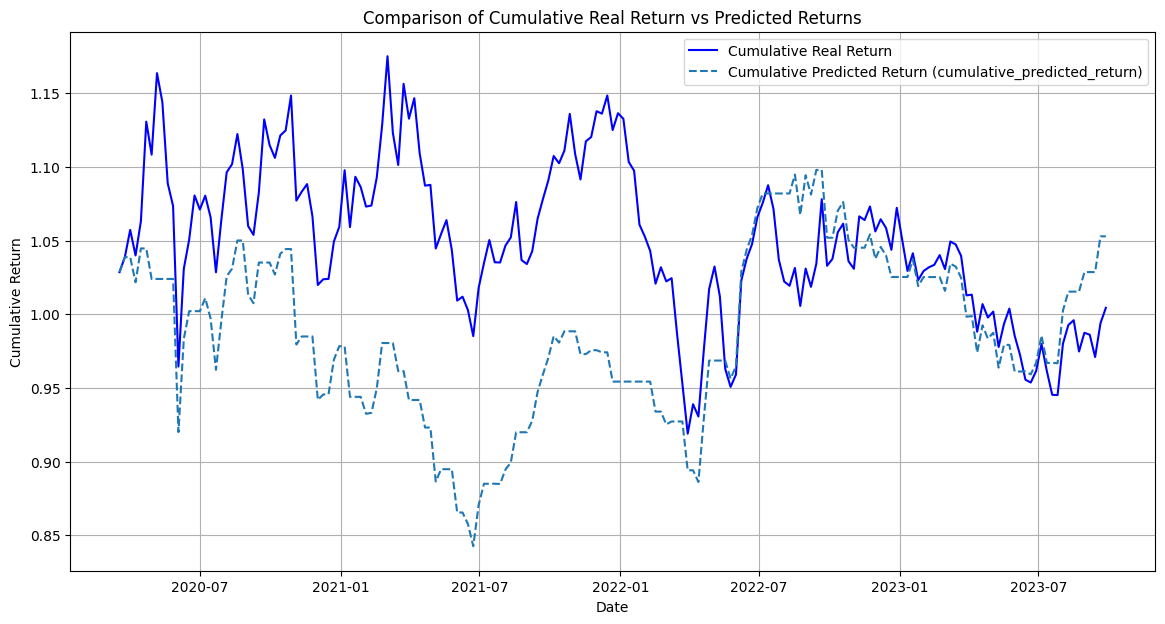

In [20]:
plot_cumulative_returns(
    data=asset_data,
    real_column="cumulative_real_return",
    predicted_columns=["cumulative_predicted_return"]
)